In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings

import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection  import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

In [2]:
def notEmpty(s):
    return s != ''

In [3]:
## 防止中文异常
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [4]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
path = "datas/boston_housing.data"
## 由于数据文件格式不统一，所以读取的时候，先按照一行一个字段属性读取数据，然后再按照每行数据进行处理
fd = pd.read_csv(path, header=None)
data = np.empty((len(fd), 14))
for i, d in enumerate(fd.values):
    # filter为过滤器，过滤不是空的内容
    # map做映射，把数据全部映射为float类型的数据
    d = map(float, filter(notEmpty, d[0].split(' ')))
    data[i] = list(d)

x, y = np.split(data, (13,), axis=1)  # x: (506, 13)  y:(506, 1)
y = y.ravel()  # (506,)

print ("样本数据量:%d, 特征个数：%d" % x.shape)
print ("target样本数据量:%d" % y.shape[0])

样本数据量:506, 特征个数：13
target样本数据量:506


In [5]:
#数据的分割，
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, train_size=0.8, random_state=14)
x_train, x_test, y_train, y_test = x_train1, x_test1, y_train1, y_test1
print ("训练数据集样本数目：%d, 测试数据集样本数目：%d" % (x_train.shape[0], x_test.shape[0]))

训练数据集样本数目：404, 测试数据集样本数目：102


C:\03ProgrammingSoftware\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
# 标准化
ss = MinMaxScaler()

x_train = ss.fit_transform(x_train, y_train)
x_test = ss.transform(x_test)

print ("原始数据各个特征属性的调整最小值:",ss.min_)
print ("原始数据各个特征属性的缩放数据值:",ss.scale_)

原始数据各个特征属性的调整最小值: [-7.10352762e-05  0.00000000e+00 -1.68621701e-02  0.00000000e+00
 -7.92181070e-01 -6.82314620e-01 -2.98661174e-02 -1.02719857e-01
 -4.34782609e-02 -3.56870229e-01 -1.34042553e+00 -6.38977636e-03
 -4.90780142e-02]
原始数据各个特征属性的缩放数据值: [1.12397589e-02 1.00000000e-02 3.66568915e-02 1.00000000e+00
 2.05761317e+00 1.91607588e-01 1.02986612e-02 9.09347180e-02
 4.34782609e-02 1.90839695e-03 1.06382979e-01 2.53562554e-03
 2.83687943e-02]


In [7]:
#构建模型（回归）
model = DecisionTreeRegressor(criterion='mae', max_depth=7)
#模型训练
model.fit(x_train, y_train)
#模型预测
y_test_hat = model.predict(x_test) 

In [8]:
#评估模型
score = model.score(x_test, y_test)
print ("Score：", score)

Score： 0.8087182425381402


In [9]:
#构建线性回归
lr = LinearRegression()
lr.fit(x_train,y_train)
lr_y_test_hat = lr.predict(x_test)
lr_score = lr.score(x_test, y_test)
print ("lr:", lr_score)
#构建lasso
lasso = LassoCV(alphas=np.logspace(-3,1,20))
lasso.fit(x_train, y_train)
lasso_y_test_hat = lasso.predict(x_test)
lasso_score = lasso.score(x_test, y_test)
print ("lasso:", lasso_score)
#构建岭回归
ridge = RidgeCV(alphas=np.logspace(-3,1,20))
ridge.fit(x_train, y_train)
ridge_y_test_hat = ridge.predict(x_test)
ridge_score = ridge.score(x_test, y_test)
print ("ridge:", ridge_score)

lr: 0.6177265992293741
lasso: 0.617887746021268
ridge: 0.6209247731651967


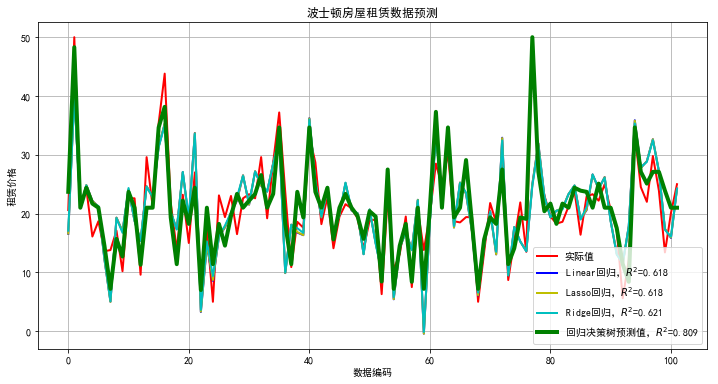

In [10]:
## 7. 画图
plt.figure(figsize=(12,6), facecolor='w')
ln_x_test = range(len(x_test))

plt.plot(ln_x_test, y_test, 'r-', lw=2, label=u'实际值')
plt.plot(ln_x_test, lr_y_test_hat, 'b-', lw=2, label=u'Linear回归，$R^2$=%.3f' % lr_score)
plt.plot(ln_x_test, lasso_y_test_hat, 'y-', lw=2, label=u'Lasso回归，$R^2$=%.3f' % lasso_score)
plt.plot(ln_x_test, ridge_y_test_hat, 'c-', lw=2, label=u'Ridge回归，$R^2$=%.3f' % ridge_score)
plt.plot(ln_x_test, y_test_hat, 'g-', lw=4, label=u'回归决策树预测值，$R^2$=%.3f' % score)
plt.xlabel(u'数据编码')
plt.ylabel(u'租赁价格')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.title(u'波士顿房屋租赁数据预测')
plt.show()

In [11]:
# 参数优化
pipes = [
    Pipeline([
            ('mms', MinMaxScaler()), ## 归一化操作
            ('pca', PCA()), ## 降纬
            ('decision', DecisionTreeRegressor(criterion='mse'))
        ]),
    Pipeline([
            ('mms', MinMaxScaler()),
            ('decision', DecisionTreeRegressor(criterion='mse'))
        ]),
    Pipeline([
            ('decision', DecisionTreeRegressor(criterion='mse'))
        ])
]

# 参数
parameters = [
    {
        "pca__n_components": [0.25,0.5,0.75,1],
        "decision__max_depth":  np.linspace(1,20,20).astype(np.int8)
    },
    {
        "decision__max_depth":  np.linspace(1,20,20).astype(np.int8)
    },
    {
        "decision__max_depth":  np.linspace(1,20,20).astype(np.int8)
    }
]
#获取数据
x_train2, x_test2, y_train2, y_test2 = x_train1, x_test1, y_train1, y_test1

for t in range(3):
    pipe = pipes[t]

    gscv = GridSearchCV(pipe, param_grid=parameters[t])

    gscv.fit(x_train2, y_train2)
    
    print (t, "score值:", gscv.best_score_, "最优参数列表:", gscv.best_params_)

0 score值: 0.40824646300970363 最优参数列表: {'decision__max_depth': 11, 'pca__n_components': 0.75}
1 score值: 0.7194300349571684 最优参数列表: {'decision__max_depth': 7}
2 score值: 0.7370924223537682 最优参数列表: {'decision__max_depth': 5}


In [12]:
# 使用最优参数看看正确率
mms_best = MinMaxScaler()
decision3 = DecisionTreeRegressor(criterion='mse', max_depth=4)

x_train3, x_test3, y_train3, y_test3 = x_train1, x_test1, y_train1, y_test1
x_train3 = mms_best.fit_transform(x_train3, y_train3)
x_test3 = mms_best.transform(x_test3)
decision3.fit(x_train3, y_train3)

print ("正确率:", decision3.score(x_test3, y_test3))

正确率: 0.8435980902870441


1深度，正确率0.32761
2深度，正确率0.62189
3深度，正确率0.78241
4深度，正确率0.84360
5深度，正确率0.85422
6深度，正确率0.81827
7深度，正确率0.81830
8深度，正确率0.81797
9深度，正确率0.81510
10深度，正确率0.83153
11深度，正确率0.82989
12深度，正确率0.77876
13深度，正确率0.79220
14深度，正确率0.77530
15深度，正确率0.81837
16深度，正确率0.77201
17深度，正确率0.80935
18深度，正确率0.79170
19深度，正确率0.78697


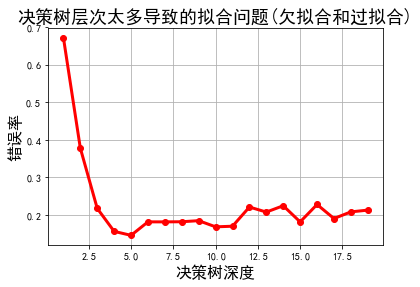

In [13]:
#查看各个不同深度的错误率
x_train4, x_test4, y_train4, y_test4 = x_train1, x_test1, y_train1, y_test1

depths = np.arange(1, 20)
err_list = []
for d in depths:
    clf = DecisionTreeRegressor(criterion='mse', max_depth=d)
    clf.fit(x_train4, y_train4)
    
    score1 = clf.score(x_test4, y_test4)
    err = 1 - score1
    err_list.append(err)
    print ("%d深度，正确率%.5f" % (d, score1))

## 画图
plt.figure(facecolor='w')
plt.plot(depths, err_list, 'ro-', lw=3)
plt.xlabel(u'决策树深度', fontsize=16)
plt.ylabel(u'错误率', fontsize=16)
plt.grid(True)
plt.title(u'决策树层次太多导致的拟合问题(欠拟合和过拟合)', fontsize=18)
plt.show()